# Support Vector Machine

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from os import path
%matplotlib inline

In [2]:
# Import Dataset
train_data = path.join('Task5_DataSet' , '01_train.csv')
train_data = pd.read_csv(train_data)
print(train_data.shape)
train_data.head(10)

(100, 3)


,x0,x1,y
0,416,627,-1
1,-51,298,-1
2,-519,1158,-1
3,626,1136,-1
4,925,-429,-1
5,830,-939,-1
6,628,176,-1
7,433,285,-1
8,1824,-818,-1
9,992,1214,-1


In [3]:
test_data = path.join('Task5_DataSet' , '01_test.csv')
test_data = pd.read_csv(test_data)
print(test_data.shape)
test_data.head(10)

(1024, 3)


,x0,x1,y
0,-908,-1663,1
1,558,-1851,1
2,-580,-110,1
3,-1613,-1018,1
4,-1136,94,1
5,-552,-1076,1
6,-232,426,-1
7,868,733,-1
8,297,-772,1
9,-25,828,-1


In [4]:
train_data = np.array(train_data).astype('float64')
test_data = np.array(test_data).astype('float64')

In [5]:
class SVM:
    def __init__(self, x, y, C, kernel, alphas, b, errors):
        self.x = x
        self.y = y 
        self.C = C 
        self.kernel = kernel 
        self.alphas = alphas 
        self.b = b 
        self.errors = errors 
        self._obj = []  
        self.m = len(self.x)


def kernel_linear(x, y, b=1):

    return x @ y.T + b


def kernel_gaussian(x, y, sigma=1):
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result


def objective_function(alphas, target, kernel, X_train):
    return np.sum(alphas) - 0.5 * np.sum(
        (target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alphas[:, None] * alphas[None, :]))


def decision_function(alphas, target, kernel, X_train, x_test, b):
    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result



In [6]:
def plot_boundaries(model, resolution=100, colors=('g', 'b', 'r'), levels=(-1, 0, 1)):
        fig, ax = plt.subplots()
        xrange = np.linspace(model.x[:, 0].min(), model.x[:, 0].max(), resolution)
        yrange = np.linspace(model.x[:, 1].min(), model.x[:, 1].max(), resolution)
        grid = [[decision_function(model.alphas, model.y,
                                   model.kernel, model.x,
                                   np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))

        ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.x[:, 0], model.x[:, 1],
                   c=model.y, lw=0, alpha=0.25)

        mask = np.round(model.alphas, decimals=2) != 0.0
        ax.scatter(model.x[mask, 0], model.x[mask, 1],
                   c=model.y[mask], lw=1, edgecolors='k')

        return grid, ax


def step(iteration1, iteration2, model):
    if iteration1 == iteration2:
        return 0, model

    E1, E2, alph1, alph2, s, y1, y2 = initialize_step_variables(iteration1, iteration2, model)

    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    k11 = model.kernel(model.x[iteration1], model.x[iteration1])
    k12 = model.kernel(model.x[iteration1], model.x[iteration2])
    k22 = model.kernel(model.x[iteration2], model.x[iteration2])
    eta = 2 * k12 - k11 - k22

    if (eta < 0):
        a2 = update_a_when_eta_lt_zero(E1, E2, H, L, alph2, eta, y2)

    else:
        a2 = update_a_when_eta_g_zero(H, L, alph2, iteration2, model)

    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C

    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model

    a1 = alph1 + s * (alph2 - a2)

    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b

    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    else:
        b_new = (b1 + b2) * 0.5

    model.alphas[iteration1] = a1
    model.alphas[iteration2] = a2

    updated_bais_on_error(a1, a2, alph1, alph2, b_new, iteration1, iteration2, model, y1, y2)

    return 1, model


def update_a_when_eta_g_zero(H, L, alph2, iteration2, model):
    alphas_adj = model.alphas.copy()
    alphas_adj[iteration2] = L
    Lobj = objective_function(alphas_adj, model.y, model.kernel, model.x)
    alphas_adj[iteration2] = H
    Hobj = objective_function(alphas_adj, model.y, model.kernel, model.x)
    if Lobj > (Hobj + eps):
        a2 = L
    elif Lobj < (Hobj - eps):
        a2 = H
    else:
        a2 = alph2
    return a2


def update_a_when_eta_lt_zero(E1, E2, H, L, alph2, eta, y2):
    a2 = alph2 - y2 * (E1 - E2) / eta
    if L < a2 < H:
        a2 = a2
    elif (a2 <= L):
        a2 = L
    elif (a2 >= H):
        a2 = H
    return a2


def initialize_step_variables(iteration1, iteration2, model):
    alph1 = model.alphas[iteration1]
    alph2 = model.alphas[iteration2]
    y1 = model.y[iteration1]
    y2 = model.y[iteration2]
    E1 = model.errors[iteration1]
    E2 = model.errors[iteration2]
    s = y1 * y2
    return E1, E2, alph1, alph2, s, y1, y2


def updated_bais_on_error(a1, a2, alph1, alph2, b_new, iteration1, iteration2, model, y1, y2):
    for index, alph in zip([iteration1, iteration2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0
    non_opt = [n for n in range(model.m) if (n != iteration1 and n != iteration2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1 * (a1 - alph1) * model.kernel(model.x[iteration1], model.x[non_opt]) + \
                            y2 * (a2 - alph2) * model.kernel(model.x[iteration2], model.x[non_opt]) + model.b - b_new
    model.b = b_new


def examine_example(i2, model):
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):

        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = step(i1, i2, model)
            if step_result:
                return 1, model

        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = step(i1, i2, model)
            if step_result:
                return 1, model

        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = step(i1, i2, model)
            if step_result:
                return 1, model

    return 0, model



In [7]:
def fit(model):
    num_changed = 0
    examine_all = 1

    while (num_changed > 0) or (examine_all):
        num_changed = 0
        if examine_all:
            for i in range(model.alphas.shape[0]):
                model, num_changed = do_examine(i, model, num_changed)
        else:
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                model, num_changed = do_examine(i, model, num_changed)
        if examine_all == 1:
            examine_all = 0
        elif num_changed == 0:
            examine_all = 1

    return model


def do_examine(i, model, num_changed):
    examine_result, model = examine_example(i, model)
    num_changed += examine_result
    if examine_result:
        obj_result = objective_function(model.alphas, model.y, model.kernel, model.x)
        model._obj.append(obj_result)
    return model, num_changed


def predict(alphas, target, kernel, X_train, x_test, b):
    pred = np.sign((alphas * target) @ kernel(X_train, x_test) + b)
    return pred

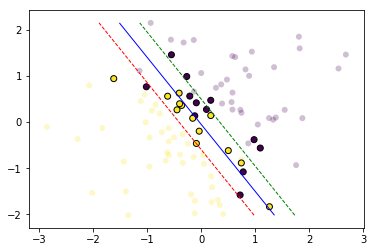

In [8]:
x_train = train_data[:, :-1]
y_train = train_data[:, -1]
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train, y_train)
C = 1.0
m = len(x_train)
initial_alphas = np.zeros(m)
initial_b = 0.0
tol = 0.01
eps = 0.01

model = SVM(x_train, y_train, C, kernel_linear,
            initial_alphas, initial_b, np.zeros(m))
model.errors = decision_function(model.alphas, model.y, model.kernel,
                                  model.x, model.x, model.b) - model.y
output = fit(model)
grid, ax = plot_boundaries(output)


x_test = test_data[:, :-1]
y_test = test_data[:, -1]
cdf = predict(model.alphas, model.y, model.kernel, model.x, x_test, model.b)
result = pd.DataFrame({'Predicted': cdf, 'actual': y_test})

plt.show()